## MACHINE LEARNING PROJECT: PREDICTING FORMULA 1 RESULTS

Ramón Fernández Cerezo

### 1. Introduction

Formula 1 is a very complex sport, where results depend on a lot of factors, from the engineering behind the car, to the weather forecast. Of course, we will admit that driver's ability plays an important role in order to know how a race is going to finish, although some haters doubt it. Every sport has a certain part of uncertainty, which makes them funnier, but in this project we are going to minimize that, until we get the better predictions possible.

**Why do we need to know the results of a race before it happen?**

There are several reasons:

- First that come to mind is betting odds. With a high and safe ML model, we could reach an interesting benefit along the season.

- A model like this could also be an objective reason to convince a company to be a sponsor, or to sign a more benefitial contract. 

- Also, Formula 1 teams usually have systems to decide which driver to help more and, in some occasion, which one they would sacrifice in order to help the main driver to win. But those decissions are not easy to take, and having an objective model that tells you which driver has more chances to get a bunch of points would help to avoid a lot of controversial situations between teammates.

**Objectives**

- Create a **ML classifier model** to predict the final results of a race based on previous features.
- Understand the different features that have influence in the final results, and emphasize in them.

### 2. Creating our dataset

The original database we will use comes from the API: 'http://ergast.com/mrd/'. Nevertheless, someone already did the work for us, because we can obtain the same dataset from Kaggle: 'https://www.kaggle.com/datasets/rohanrao/formula-1-world-championship-1950-2020', divided in 13 csv files.

#### 2.1. Reading CSVs

In [61]:
import pandas as pd

results = pd.read_csv('Formula 1 Actualizad/results.csv')
qualifying = pd.read_csv('Formula 1 Actualizad/qualifying.csv')
races = pd.read_csv('Formula 1 Actualizad/races.csv')
constructors = pd.read_csv('Formula 1 Actualizad/constructors.csv')
drivers = pd.read_csv('Formula 1 Actualizad/drivers.csv')
lap_times = pd.read_csv('Formula 1 Actualizad/lap_times.csv')
circuits = pd.read_csv('Formula 1 Actualizad/circuits.csv')
driver_standings = pd.read_csv("Formula 1 Actualizad/driver_standings.csv")
constructor_standings = pd.read_csv("Formula 1 Actualizad/constructor_standings.csv")

#### 2.2 Merging CSVs

##### MERGE 1 - dff1 
+ Race results : To obtain positions, resultId to identify every observation, points, rythm, fastest lap and status
+ qualifying results : to obtain qualifying positions and lap times

**On raceId, driverId and constructorId, the skeleton of most of our merges**

In [62]:
dff1 = pd.merge(results, qualifying, on=['raceId', 'driverId', 'constructorId'], how= 'outer')

#### MERGE 2 - dff2
+ dff1 (results + qualifying)
+ races : to obtain year and GP order (column 'round')

**Extra steps:** 
1. Drop every unnecesary column by now (dates and times of different events, driver number -because we already have the Id-, urls)
2. Drop every row from seasons before 2017

In [63]:
dff2 = pd.merge(dff1, races, on='raceId')
dff2.drop(['time_y', 'url', 'fp1_date', 'fp1_time', 'fp2_date', 'fp2_time',
       'fp3_date', 'fp3_time', 'quali_date', 'quali_time', 'sprint_date',
       'sprint_time', 'name', 'date', 'number_y', 'number_x', 'position_x'], axis=1, inplace=True)
dff2 = dff2[dff2['year']>=2017]

#### MERGE 3 - dff3

+ dff2 (results + qualifying + races)
+ constructors: to associate the name of the team with every constructorId for a better visual understanding of the dataFrame

In [64]:
dff3 = pd.merge(dff2, constructors[['constructorId', 'name']], on = 'constructorId')

#### MERGE 4 - dff4

+ dff3 (results + qualifying + races + constructors)
+ drivers: to associate drivers surnames with every driversId for a better visual understanding of the dataFrame

In [65]:
dff4 = pd.merge(dff3, drivers[['driverId', 'surname']], on='driverId')

#### MERGE 5 - dff5

**Previous step:** groupby of every laptimes per driver per race, taking the average value of all of them

+ dff4 (results + qualifying + races + constructors)
+ average_laptimes

In [66]:
average_laptimes = lap_times.groupby(['raceId', 'driverId'])[['milliseconds']].mean()
average_laptimes.reset_index(level=['raceId', 'driverId'], inplace=True)
dff5 = pd.merge(dff4, average_laptimes, on= ['raceId', 'driverId'], how='left')

#### MERGE 6 - dff6
+ dff5 (results + qualifying + races + constructors + average lap times)
+ circuits: to associate circuit names with every circuitId for a better visual understanding of the dataFrame

In [67]:
dff6 = pd.merge(dff5, circuits[['circuitId', 'circuitRef']], on='circuitId')

#### MERGE 7 - dff7

+ dff6 (results + qualifying + races + constructors + average lap times + circuits)
+ driver_standings: to obtain points and number of victories of each driver

In [68]:
dff7 = pd.merge(dff6, driver_standings, on= ['raceId','driverId'])

#### MERGE 8 - dff8
+ dff7 (results + qualifying + races + constructors + average lap times + circuits + driver_standings)
+ constructor standings: to obtain points and number of victories of each team

In [69]:
dff8 = pd.merge(dff7, constructor_standings, on = ['raceId', 'constructorId'], suffixes=['_driver', '_constructor'])

#### 3. Feature Engineering

In our dataset we obtain data from the results of the current races, but it is non-sense to predict a result that we already know. The point of most of our feature engineering is to create new columns that only use information already existing before the beginning of the race, or trying to predict a concrete feature of the race.

1. 'DNF'

In [70]:
dff8['DNF'] = dff8['positionText_x'][dff8['positionText_x']== 'R']
dff8['DNF'].replace('R', 1, inplace=True)
dff8['DNF'].fillna(0, inplace=True)             # New column with a boolean that is True (1) if DNF, and False (0), if it was not

2. Average points per race and driver until the current race

In [71]:
dff8['Pts Cmp'] = (dff8['points_y'] - dff8['points_x']) / (dff8['round']-1)
dff8['Pts Cmp'].fillna(0, inplace=True)

3. Average points per race and team until the current race

In [72]:
target_mean = dff8.groupby(['raceId', 'constructorId'])['points_x'].sum().rename('Team points in that race')

dff8 = dff8.join(target_mean, on=['raceId', 'constructorId'])

dff8['Pts Con'] = (dff8['points'] - dff8['Team points in that race'])/ (dff8['round']-1)

dff8['Pts Con'].fillna(0, inplace= True)    # groupby to get team points in each race, add to the dataset, substract from total points
                                            # and divide by the number of GP's to get the average per race

In [73]:
dff8.sort_values(by='resultId', inplace=True)

4. Start from pitlane (bool)

We realize that starting from pitlane for is defined by our dataset as starting in position 0, which does not make any sense, so we consider it as the position 21, because it is much worse than being in the last position of the grid, and to create a boolean about it.

In [74]:
dff8['grid'].replace(0, 21, inplace=True)
dff8['Start From Pitlane'] = 0
dff8['Start From Pitlane'].where(dff8['grid'] != 21, 1, inplace=True)

5. Gained/Lost positions

In [75]:
dff8['Gained/Lost positions'] = dff8['grid'] - dff8['positionOrder']
dff8['Total Gained/Lost positions'] = dff8.groupby(['driverId', 'year'])['Gained/Lost positions'].cumsum()
dff8['TTotal Gained/Lost positions'] = dff8['Total Gained/Lost positions'] - dff8['Gained/Lost positions']

# Grouped by driver and year, we get all the positions gained and lost in the whole season

6. DNF INDEX (DNF PER DRIVER/TEAM * AVERAGE DNF PER CIRCUIT)

+ Attempt to create an index to guess DNF in the race

In [76]:
dnf_driver_mean = dff8.groupby(['year', 'driverId'])['DNF'].mean().rename('DNF/driver')
dff8 = dff8.join(dnf_driver_mean, on=['year', 'driverId'])

dnf_circuit_mean = dff8.groupby(['year', 'circuitId'])['DNF'].sum().rename('DNF/circuit')
dff8 = dff8.join(dnf_circuit_mean, on=['year', 'circuitId'])

dnf_constructor_mean = dff8.groupby(['year', 'constructorId'])['DNF'].mean().rename('DNF/constructor')
dff8 = dff8.join(dnf_constructor_mean, on=['year', 'constructorId'])

In [77]:
dff8['Index DNF/Driver'] = dff8['DNF/driver'] * dff8['DNF/circuit']
dff8['Index DNF/Constructor'] = dff8['DNF/constructor'] * dff8['DNF/circuit']

7. Average Lost Laps in the season
+ In order to understand and give our model a better information about the lower positions

In [78]:
dff8['Lost Laps'] = 0
dff8['Lost Laps'].where(dff8['statusId'] != 11, 1, inplace=True)
dff8['Lost Laps'].where(dff8['statusId'] != 12, 2, inplace=True)
dff8['Lost Laps'].where(dff8['statusId'] != 13, 3, inplace=True)
dff8['Lost Laps'].where(dff8['statusId'] != 14, 4, inplace=True)
dff8['Lost Laps'].where(dff8['statusId'] != 15, 5, inplace=True)
dff8['Lost Laps'].where(dff8['statusId'] != 16, 6, inplace=True)

dff8['Sum of Lost Laps'] = dff8.groupby(['driverId', 'year'])['Lost Laps'].cumsum()
dff8['Sum of Lost Laps before the race'] = dff8['Sum of Lost Laps'] - dff8['Lost Laps']
dff8['Average Lost Laps'] = dff8['Sum of Lost Laps before the race'] / (dff8['round'] - 1)
dff8['Average Lost Laps'].fillna(0, inplace=True)

In [79]:
dff8['position_y'][dff8['position_y'].isna()] = 20

8. Average Speed per circuit (Source: F1) 
* No correlation found
* Source: F1

In [80]:
dff8['circuitRef'].unique()
dff8['Circuit_speed'] = dff8['circuitRef'].map({'albert_park': 211, 'bahrain': 201, 'shanghai': 194, 
      'baku': 202, 'catalunya': 193, 'monaco': 153, 'villeneuve': 202, 'ricard': 219, 'red_bull_ring':225,
      'silverstone':225, 'hockenheimring': 207, 'hungaroring':186, 'spa':224, 'monza':241, 'marina_bay':164,
      'sochi':211, 'suzuka': 215, 'americas': 196, 'rodriguez': 190, 'interlagos': 206,
      'yas_marina': 192, 'mugello': 232, 'nurburgring': 196, 'portimao': 207, 'imola': 224,
      'istanbul':207, 'zandvoort': 205, 'losail': 223, 'jeddah':240, 'miami':209})

9. Position in the last races

In [81]:
def add_previous_races(df, n):
    """
    Add columns to the dataframe with the results of the last n races for each driver.
    
    Parameters:
    df (DataFrame): The input dataframe with driver results.
    n (int): The number of previous races to include in the output dataframe.
    
    Returns:
    None
    """
    # Group the dataframe by the driver column
    grouped = df.groupby('driverId')
    
    # Initialize a list to store the shifted values
    shifted_values = []
    
    # Shift the values within each group n times to get the results of the previous races
    for i in range(1, n + 1):
        shifted_values.append(grouped['positionOrder'].shift(i))
    
    # Concatenate the shifted values with the original dataframe
    new_cols = [f'Result_Race-{i}' for i in range(1, n + 1)]
    for i, col in enumerate(new_cols):
        df[col] = shifted_values[i]
    
    return None

# Call the function to add the results of the last 5 races as new columns in the existing dataframe
add_previous_races(dff8, 5)

# Print the resulting dataframe

In [82]:
dff8['Result_Race-1'].fillna(10, inplace=True)
dff8['Result_Race-2'].fillna(10, inplace=True)
dff8['Result_Race-3'].fillna(10, inplace=True)
dff8['Result_Race-4'].fillna(10, inplace=True)
dff8['Result_Race-5'].fillna(10, inplace=True)

## FINAL DATASET 

In [83]:
dffinal = pd.DataFrame({'ResultId': dff8['resultId'], 'RaceId': dff8['raceId'], 'Year': dff8['year'], 'GP' : dff8['round'],
                'CircuitId': dff8['circuitId'], 'DriverId': dff8['driverId'], 'ConstructorId': dff8['constructorId'],
                'Constructor Name': dff8['name'], 'Driver Name':dff8['surname'], 'Circuit': dff8['circuitRef'],
                'Final position': dff8['positionOrder'], 'DNF': dff8['DNF'], 
                'Fastest Lap Rank': dff8['rank'], 'Grid position': dff8['grid'], 'Average pace': dff8['milliseconds_y'], 
                'Q1': dff8['q1'], 'Q2': dff8['q2'], 'Q3': dff8['q3'], 'Qualifying position': dff8['position_y'],
                'Victories': dff8['wins_driver'], 'Drivers points': dff8['Pts Cmp'],
                'Constructors points': dff8['Pts Con'], 'Constructors victories': dff8['wins_constructor'],
                'Start from Pitlane': dff8['Start From Pitlane'], 
                'Total gained/lost positions': dff8['TTotal Gained/Lost positions'], 
                'Index DNF/Driver': dff8['Index DNF/Driver'], 'Index DNF/Constructor': dff8['Index DNF/Constructor'],
                'Average Lost laps': dff8['Average Lost Laps'], 'Circuit Speed': dff8['Circuit_speed'],
                'Result_Race-1': dff8['Result_Race-1'], 'Result_Race-2': dff8['Result_Race-2'],
                'Result_Race-3': dff8['Result_Race-3'], 'Result_Race-4': dff8['Result_Race-4'],
                'Result_Race-5': dff8['Result_Race-5']})
dffinal.columns

Index(['ResultId', 'RaceId', 'Year', 'GP', 'CircuitId', 'DriverId',
       'ConstructorId', 'Constructor Name', 'Driver Name', 'Circuit',
       'Final position', 'DNF', 'Fastest Lap Rank', 'Grid position',
       'Average pace', 'Q1', 'Q2', 'Q3', 'Qualifying position', 'Victories',
       'Drivers points', 'Constructors points', 'Constructors victories',
       'Start from Pitlane', 'Total gained/lost positions', 'Index DNF/Driver',
       'Index DNF/Constructor', 'Average Lost laps', 'Circuit Speed',
       'Result_Race-1', 'Result_Race-2', 'Result_Race-3', 'Result_Race-4',
       'Result_Race-5'],
      dtype='object')

**Dataset to csv**

In [84]:
dffinal.to_csv('F1.csv', header=True, index=True)

### 4. EDA + Some more featuring + Target creation

In [85]:
df = pd.read_csv('F1.csv', index_col='ResultId')
df.drop("Unnamed: 0", axis= 1, inplace=True)
df.head()

,RaceId,Year,GP,CircuitId,DriverId,ConstructorId,Constructor Name,Driver Name,Circuit,Final position,...,Total gained/lost positions,Index DNF/Driver,Index DNF/Constructor,Average Lost laps,Circuit Speed,Result_Race-1,Result_Race-2,Result_Race-3,Result_Race-4,Result_Race-5
ResultId,,,,,,,,,,,,,,,,,,,,,
23379.0,969,2017,1,1,20,6,Ferrari,Vettel,albert_park,1.0,...,0.0,0.70,0.875,0.0,211.0,10.0,10.0,10.0,10.0,10.0
23380.0,969,2017,1,1,1,131,Mercedes,Hamilton,albert_park,2.0,...,0.0,0.00,0.175,0.0,211.0,10.0,10.0,10.0,10.0,10.0
23381.0,969,2017,1,1,822,131,Mercedes,Bottas,albert_park,3.0,...,0.0,0.35,0.175,0.0,211.0,10.0,10.0,10.0,10.0,10.0
23382.0,969,2017,1,1,8,6,Ferrari,Räikkönen,albert_park,4.0,...,0.0,1.05,0.875,0.0,211.0,10.0,10.0,10.0,10.0,10.0
23383.0,969,2017,1,1,830,9,Red Bull,Verstappen,albert_park,5.0,...,0.0,2.45,2.275,0.0,211.0,10.0,10.0,10.0,10.0,10.0


In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 2460 entries, 23379.0 to 25845.0
Data columns (total 33 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   RaceId                       2460 non-null   int64  
 1   Year                         2460 non-null   int64  
 2   GP                           2460 non-null   int64  
 3   CircuitId                    2460 non-null   int64  
 4   DriverId                     2460 non-null   int64  
 5   ConstructorId                2460 non-null   int64  
 6   Constructor Name             2460 non-null   object 
 7   Driver Name                  2460 non-null   object 
 8   Circuit                      2460 non-null   object 
 9   Final position               2460 non-null   float64
 10  DNF                          2460 non-null   float64
 11  Fastest Lap Rank             2460 non-null   int64  
 12  Grid position                2460 non-null   float64
 13  Average

In [87]:
df.describe()

,RaceId,Year,GP,CircuitId,DriverId,ConstructorId,Final position,DNF,Fastest Lap Rank,Grid position,...,Total gained/lost positions,Index DNF/Driver,Index DNF/Constructor,Average Lost laps,Circuit Speed,Result_Race-1,Result_Race-2,Result_Race-3,Result_Race-4,Result_Race-5
count,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,...,2460.000000,2460.000000,2460.000000,2460.000000,2440.000000,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000
mean,1031.341463,2019.536585,10.821138,28.308943,655.658537,69.665041,10.500000,0.151220,9.688618,10.559756,...,0.619919,0.509302,0.508935,0.337179,205.557377,10.456098,10.426423,10.408537,10.385772,10.364228
std,37.096936,1.731429,6.025610,26.302006,335.646406,85.020075,5.767454,0.358336,5.861194,5.830401,...,20.045086,0.526924,0.463256,0.376062,19.942126,5.721696,5.682664,5.650252,5.614674,5.577421
min,969.000000,2017.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,...,-81.000000,0.000000,0.000000,0.000000,153.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,999.000000,2018.000000,6.000000,9.000000,815.000000,4.000000,5.750000,0.000000,5.000000,6.000000,...,-9.000000,0.150000,0.181818,0.000000,193.000000,6.000000,6.000000,6.000000,6.000000,6.000000
50%,1030.000000,2019.000000,11.000000,17.000000,830.000000,9.000000,10.500000,0.000000,10.000000,11.000000,...,0.000000,0.314145,0.363636,0.272727,206.000000,10.000000,10.000000,10.000000,10.000000,10.000000
75%,1064.000000,2021.000000,16.000000,39.000000,842.000000,131.000000,15.250000,0.000000,15.000000,16.000000,...,12.000000,0.686364,0.714286,0.500000,224.000000,15.000000,15.000000,15.000000,15.000000,15.000000
max,1096.000000,2022.000000,22.000000,79.000000,856.000000,214.000000,20.000000,1.000000,20.000000,21.000000,...,66.000000,5.000000,2.800000,3.000000,241.000000,20.000000,20.000000,20.000000,20.000000,20.000000


In [88]:
import warnings
warnings.filterwarnings("ignore")

4.1 Establishing TARGET (Option 1)

In [89]:
df['¿Points?'] = 0
df['¿Points?'][df['Final position'] <=10] = 1
df['¿Points?'][df['Final position'] > 10] = 0

4.2 Establishing TARGET (Option 2)

In [90]:
df['Position 5'] = 0
df['Position 5'][df['Final position'] <=5] = '1) 1-5'
df['Position 5'][(df['Final position'] >= 6) & (df['Final position']<=10)] = '2) 6-10'
df['Position 5'][(df['Final position'] >= 11) & (df['Final position']<=15)] = '3)11-15'
df['Position 5'][df['Final position'] >= 16] = '4) 16-20'

* Not necessary to mention that target counts are balanced because in every race there are 10 drivers in the points and 10 that are not, same when dividing the results in groups of 5

<AxesSubplot:>

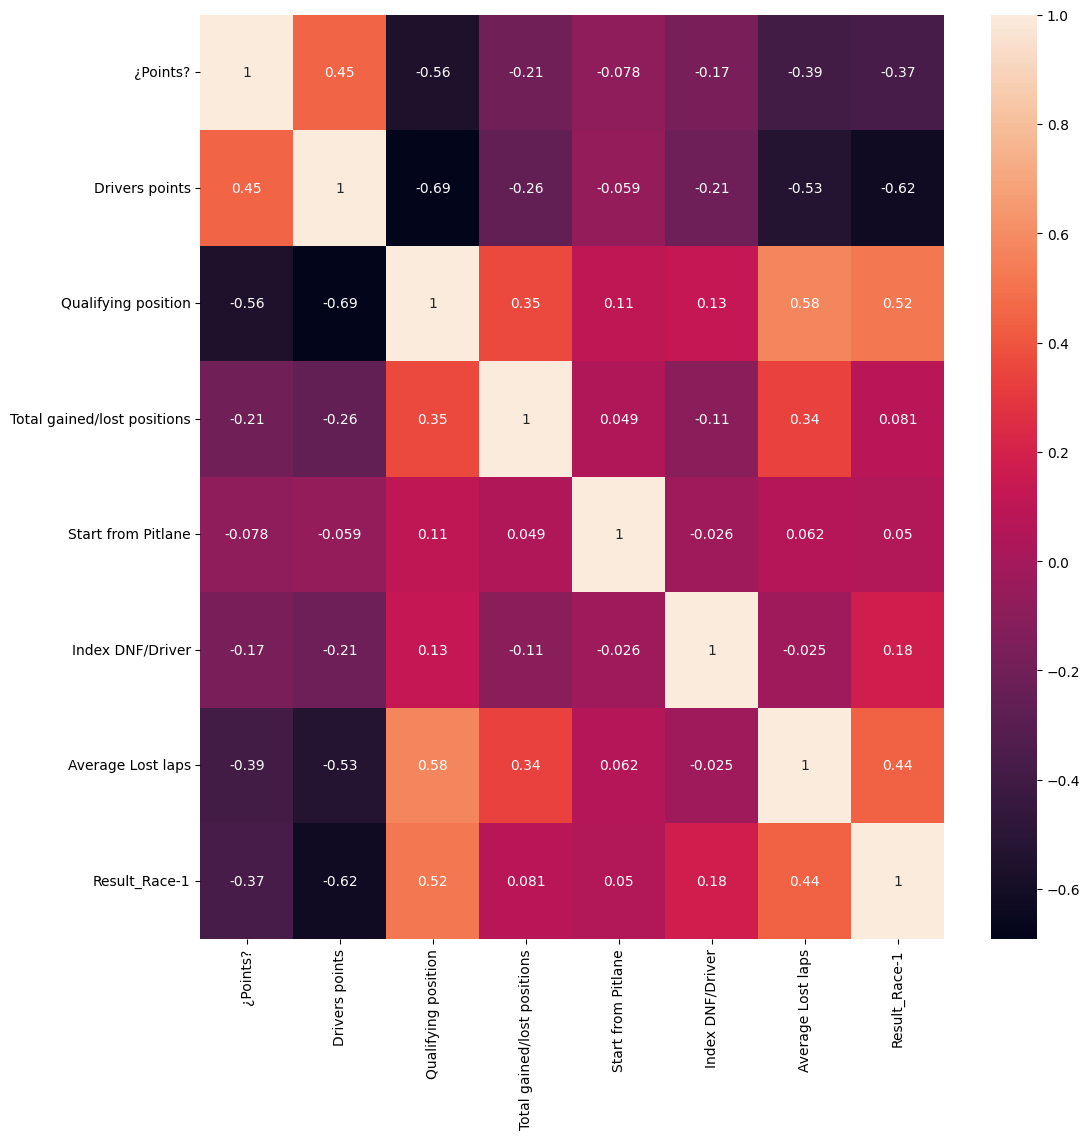

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,12))
sns.heatmap(df[['¿Points?', 'Position 5', 'Drivers points', 'Qualifying position', 
                'Total gained/lost positions', 'Start from Pitlane', 'Index DNF/Driver',
                'Average Lost laps', 'Result_Race-1']].corr(), annot=True)

## MAIN MODEL

In [92]:
X = df[['Drivers points','Qualifying position', 'Result_Race-1', 
        'Total gained/lost positions', 'Index DNF/Driver', 'Average Lost laps']][df['GP']>3]
y = df['¿Points?'][df['GP']>3]

* Eliminate the first three races of each season because we consider they are not benefitial for our train

In [93]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=200, shuffle=False)

* Choose the last ten races (200 results), because a random split would not make any sense, races are in a concrete order and with 20 drivers each

In [94]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.metrics import recall_score
from sklearn.neighbors import KNeighborsClassifier
import xgboost


pipe = Pipeline(steps=[('imputer', SimpleImputer()),
    ('classifier', RandomForestClassifier())
])

random_forest_params = {
    'classifier': [RandomForestClassifier(random_state=19)],
    'classifier__max_features': [3,4,5,6],
    'classifier__max_depth': [3,4,5,6]
}

svm_param = {
    'classifier': [svm.SVC(random_state=19)],
    'classifier__C': [0.001, 0.1, 0.5, 1],
}

xgb_param = {
    'classifier': [xgboost.XGBRFClassifier(random_state=19)],
    'classifier__n_estimators': [200],
    'classifier__booster': ['gbooster'],
    'classifier__learning_rate': [0.01, 0.1, 0.25, 0.5, 1]
}

search_space = [
    random_forest_params,
    svm_param,
    xgb_param
]

clf = GridSearchCV(estimator = pipe,
                  param_grid = search_space,
                  cv = 10,
                  scoring= "accuracy")

clf.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('classifier',
                                        RandomForestClassifier())]),
             param_grid=[{'classifier': [RandomForestClassifier(max_depth=3,
                                                                max_features=4,
                                                                random_state=19)],
                          'classifier__max_depth': [3, 4, 5, 6],
                          'classifier__max_features': [3, 4, 5, 6]},
                         {'classifier': [SVC(random_state=19)],
                          'classifier__C': [0.001, 0.1, 0.5,...
                                                         missing=nan,
                                                         monotone_constraints=None,
                                                         n_estimators=100,
                                                         

In [95]:
clf.best_params_

{'classifier': RandomForestClassifier(max_depth=3, max_features=4, random_state=19),
 'classifier__max_depth': 3,
 'classifier__max_features': 4}

In [96]:
parameters = {'n_estimators': [200],
             'max_features' : [3,4,5,6],
             "max_depth" : [3,4,5,6],
             "max_leaf_nodes": [8, 16, 24],
             "random_state" : [42]
}

rnd_clf = RandomForestClassifier()

rnd_clfCV = GridSearchCV(estimator = rnd_clf,
                  param_grid = parameters,
                  n_jobs = -1,
                  cv = 5,
                  scoring="accuracy")

rnd_clfCV.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6],
                         'max_features': [3, 4, 5, 6],
                         'max_leaf_nodes': [8, 16, 24], 'n_estimators': [200],
                         'random_state': [42]},
             scoring='accuracy')

In [97]:
rnd_clfCV.best_params_

{'max_depth': 4,
 'max_features': 6,
 'max_leaf_nodes': 8,
 'n_estimators': 200,
 'random_state': 42}

In [111]:
rnd_clf = RandomForestClassifier(n_estimators=200,
                                 max_features = 5,
                                 max_depth = 5,
                                 max_leaf_nodes=8,
                                 random_state=42)
rnd_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, max_features=5, max_leaf_nodes=8,
                       n_estimators=200, random_state=42)

In [112]:
predictions = rnd_clf.predict(X_test)
print(predictions)

[1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 1 0 0 0 0 0
 0 0 1 1 1 1 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 1 0 0 0
 0 0 0 0 1 0 1 1 1 1 0 0 1 0 1 1 0 0 0 1 0 0 0 1 0 0 1 1 1 1 1 1 1 1 0 1 0
 0 0 0 1 0 0 0 1 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 1
 1 1 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1 1 1
 1 1 0 0 1 0 0 0 0 0 0 0 1 0 1]


In [113]:
comprob = pd.DataFrame(data={'reales': y_test, 'predicciones': predictions})
comprob.groupby(['predicciones']).count()

,reales
predicciones,
0,101
1,99


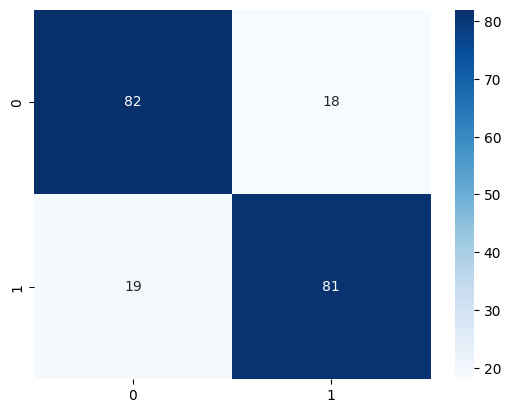

In [114]:
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np

sns.heatmap(confusion_matrix(y_test, predictions), annot=True, 
             cmap='Blues', xticklabels=np.unique(predictions), yticklabels=np.unique(predictions));

<AxesSubplot:xlabel='feature'>

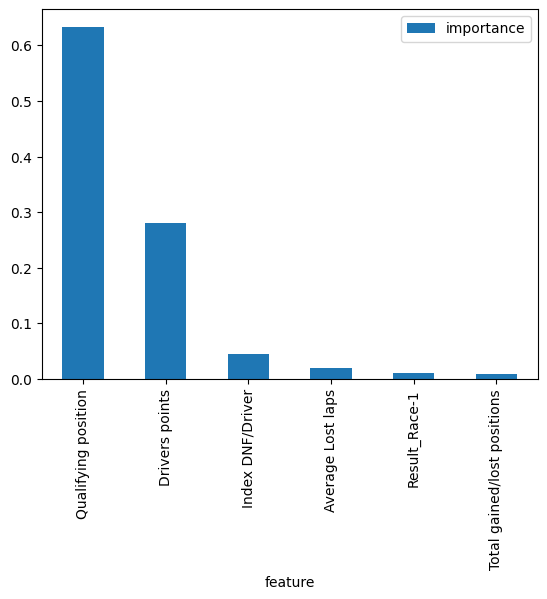

In [115]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(rnd_clf.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')

importances.plot.bar()

In [116]:
acierto = accuracy_score(y_test, predictions)

error = 1 - acierto
print("Acierto:", round(acierto*100, 2), "%")
print("Error:", round(error*100, 2), "%")

Acierto: 81.5 %
Error: 18.5 %


In [117]:
import pickle

with open('modelo.model', "wb") as archivo_salida:
    pickle.dump(rnd_clf, archivo_salida)

# MODEL 5-5-5-5

In [118]:
X = df[['Drivers points', 'Qualifying position', 'Result_Race-1', 
        'Total gained/lost positions', 'Index DNF/Driver', 'Average Lost laps']][df['GP']>3]
y = df['Position 5'][df['GP']>3]

In [129]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=200, shuffle=False)

In [130]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scal = scaler.transform(X_train)
X_test_scal = scaler.transform(X_test)

In [131]:
from sklearn.linear_model import LogisticRegression
pipe = Pipeline(steps=[('imputer', SimpleImputer()),
    ('classifier', RandomForestClassifier())
])

logistic_params = {
    'classifier': [LogisticRegression(max_iter=1000, solver='liblinear', random_state=19)],
    'classifier__penalty': ['l1', 'l2']
}

random_forest_params = {
    'classifier': [RandomForestClassifier(random_state=19)],
    'classifier__max_features': [2,3,4],
    'classifier__max_depth': [2,3,4]
}

svm_param = {
    'classifier': [svm.SVC(random_state=19)],
    'classifier__C': [0.001, 0.1, 0.5, 1, 5, 10, 100],
}

knn_param = {
    'classifier': [KNeighborsClassifier()],
    'classifier__n_neighbors': [2,3,4]
}

search_space = [
    logistic_params,
    random_forest_params,
    svm_param,
    knn_param
]

clf = GridSearchCV(estimator = pipe,
                  param_grid = search_space,
                  cv = 10,
                  scoring= "accuracy")

clf.fit(X_train_scal, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('classifier',
                                        RandomForestClassifier())]),
             param_grid=[{'classifier': [LogisticRegression(max_iter=1000,
                                                            random_state=19,
                                                            solver='liblinear')],
                          'classifier__penalty': ['l1', 'l2']},
                         {'classifier': [RandomForestClassifier(random_state=19)],
                          'classifier__max_depth': [2, 3, 4],
                          'classifier__max_features': [2, 3, 4]},
                         {'classifier': [SVC(C=0.5, random_state=19)],
                          'classifier__C': [0.001, 0.1, 0.5, 1, 5, 10, 100]},
                         {'classifier': [KNeighborsClassifier()],
                          'classifier__n_neighbors': [2, 3, 4]}]

In [132]:
clf.best_params_

{'classifier': SVC(C=0.5, random_state=19), 'classifier__C': 0.5}

In [133]:
parameters = {'n_estimators': [200, 300, 400],
             'max_features' : [3,4,5],
             "max_depth" : [2,3,4,5],
             "max_leaf_nodes": [8, 16, 24],
             "random_state" : [42]
}

rnd_clf = RandomForestClassifier()

rnd_clfCV = GridSearchCV(estimator = rnd_clf,
                  param_grid = parameters,
                  n_jobs = -1,
                  cv = 5,
                  scoring="accuracy")

rnd_clfCV.fit(X_train_scal, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5], 'max_features': [3, 4, 5],
                         'max_leaf_nodes': [8, 16, 24],
                         'n_estimators': [200, 300, 400],
                         'random_state': [42]},
             scoring='accuracy')

In [134]:
rnd_clfCV.best_params_

{'max_depth': 3,
 'max_features': 4,
 'max_leaf_nodes': 8,
 'n_estimators': 400,
 'random_state': 42}

In [144]:
rnd_clf = RandomForestClassifier(n_estimators=400,
                                 max_features = 4,
                                 max_depth = 3,
                                 max_leaf_nodes=8,
                                 random_state=42)
rnd_clf.fit(X_train_scal, y_train)

RandomForestClassifier(max_depth=3, max_features=4, max_leaf_nodes=8,
                       n_estimators=400, random_state=42)

In [145]:
predictions = rnd_clf.predict(X_test_scal)
print(predictions)

['1) 1-5' '1) 1-5' '1) 1-5' '1) 1-5' '1) 1-5' '1) 1-5' '1) 1-5' '2) 6-10'
 '2) 6-10' '3)11-15' '3)11-15' '3)11-15' '2) 6-10' '3)11-15' '2) 6-10'
 '3)11-15' '3)11-15' '3)11-15' '3)11-15' '2) 6-10' '1) 1-5' '1) 1-5'
 '1) 1-5' '1) 1-5' '2) 6-10' '1) 1-5' '2) 6-10' '3)11-15' '2) 6-10'
 '2) 6-10' '3)11-15' '2) 6-10' '3)11-15' '3)11-15' '2) 6-10' '3)11-15'
 '3)11-15' '3)11-15' '3)11-15' '1) 1-5' '1) 1-5' '1) 1-5' '1) 1-5'
 '1) 1-5' '1) 1-5' '3)11-15' '2) 6-10' '1) 1-5' '2) 6-10' '2) 6-10'
 '2) 6-10' '3)11-15' '2) 6-10' '3)11-15' '3)11-15' '3)11-15' '3)11-15'
 '3)11-15' '3)11-15' '2) 6-10' '1) 1-5' '1) 1-5' '1) 1-5' '1) 1-5'
 '1) 1-5' '1) 1-5' '2) 6-10' '2) 6-10' '3)11-15' '3)11-15' '2) 6-10'
 '3)11-15' '2) 6-10' '3)11-15' '3)11-15' '3)11-15' '2) 6-10' '3)11-15'
 '2) 6-10' '3)11-15' '1) 1-5' '1) 1-5' '1) 1-5' '2) 6-10' '3)11-15'
 '2) 6-10' '1) 1-5' '3)11-15' '1) 1-5' '2) 6-10' '3)11-15' '2) 6-10'
 '3)11-15' '1) 1-5' '2) 6-10' '3)11-15' '3)11-15' '2) 6-10' '3)11-15'
 '3)11-15' '1) 1-5' '1) 1-5

In [146]:
comprob = pd.DataFrame(data={'reales': y_test, 'predicciones': predictions})
comprob.groupby(['predicciones']).count()

,reales
predicciones,
1) 1-5,62
2) 6-10,58
3)11-15,80


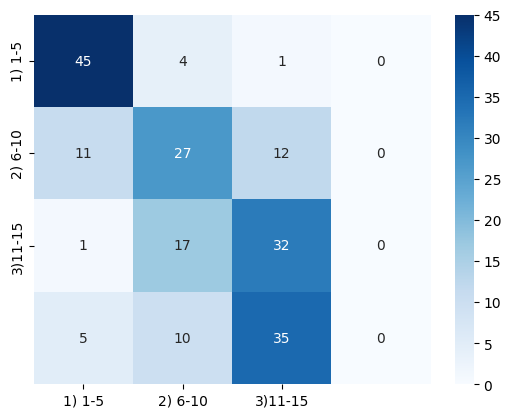

In [147]:
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, 
             cmap='Blues', xticklabels=np.unique(predictions), yticklabels=np.unique(predictions));

<AxesSubplot:xlabel='feature'>

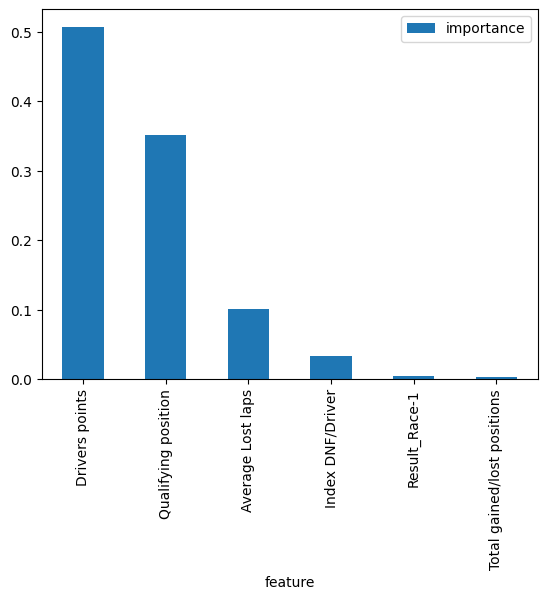

In [148]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(rnd_clf.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')

importances.plot.bar()

In [149]:
acierto = accuracy_score(y_test, predictions)

error = 1 - acierto
print("Acierto:", round(acierto*100, 2), "%")
print("Error:", round(error*100, 2), "%")

Acierto: 52.0 %
Error: 48.0 %


In [150]:
import pickle

with open('modelo5-5.model', "wb") as archivo_salida:
    pickle.dump(rnd_clfCV.best_estimator_, archivo_salida)

MODELOS EXTRA (ANALIZANDO ERROR DNF)

In [159]:
X = df[['Drivers points', 'Qualifying position', 'Result_Race-1', 
        'Total gained/lost positions', 'Index DNF/Driver', 'Average Lost laps', 'DNF']][df['GP']>3]

y = df['¿Points?'][df['GP']>3]

In [160]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=200, shuffle=False)

In [161]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scal = scaler.transform(X_train)
X_test_scal = scaler.transform(X_test)

In [162]:
rnd_clf = RandomForestClassifier(n_estimators=200,
                                 max_features = 3,
                                 max_depth = 5,
                                 max_leaf_nodes=16,
                                 random_state=42)
rnd_clf.fit(X_train_scal, y_train)

RandomForestClassifier(max_depth=5, max_features=3, max_leaf_nodes=16,
                       n_estimators=200, random_state=42)

In [163]:
predictions = rnd_clf.predict(X_test_scal)
print(predictions)

[1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 0 0 0 0 1 1 1 1 1 1 1 1 0 1 0 0 1 0 0 1 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 1 0 1 0
 0 0 0 0 0 0 1 1 1 1 0 0 1 0 1 1 0 1 0 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 1 1
 0 0 0 1 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1
 1 1 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 1 1
 1 1 0 1 1 0 0 0 0 0 0 0 1 0 0]


In [164]:
comprob = pd.DataFrame(data={'reales': y_test, 'predicciones': predictions})
comprob.groupby(['predicciones']).count()

,reales
predicciones,
0,99
1,101


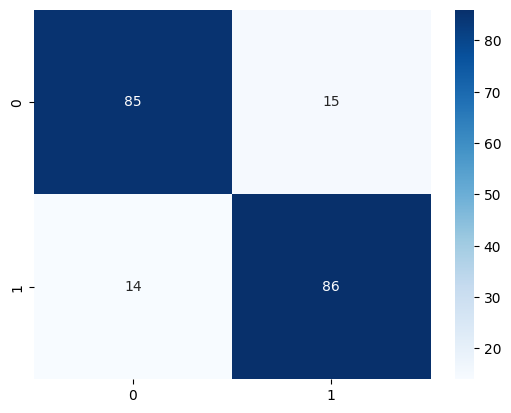

In [165]:
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, 
             cmap='Blues', xticklabels=np.unique(predictions), yticklabels=np.unique(predictions));

<AxesSubplot:xlabel='feature'>

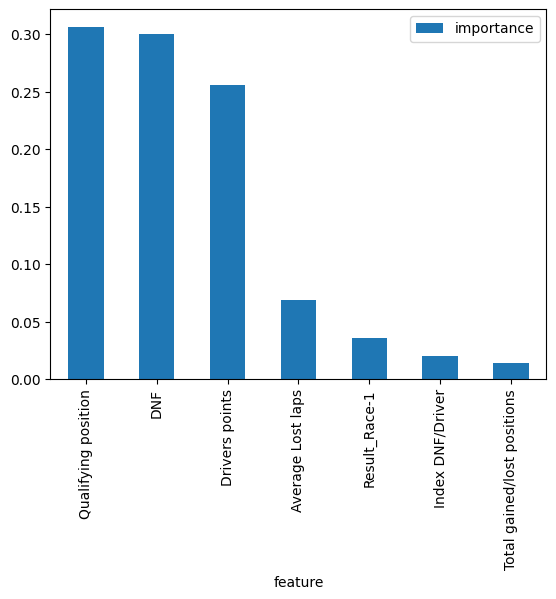

In [166]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(rnd_clf.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')

importances.plot.bar()

In [167]:
acierto = accuracy_score(y_test, predictions)

error = 1 - acierto
print("Acierto:", round(acierto*100, 2), "%")
print("Error:", round(error*100, 2), "%")

Acierto: 85.5 %
Error: 14.5 %


In [168]:
import pickle

with open('modelo-DNF1.model', "wb") as archivo_salida:
    pickle.dump(rnd_clfCV.best_estimator_, archivo_salida)

### OTHER EXAMPLE OF HOW ERROR WORKS

In [169]:
X = df[['Drivers points', 'Qualifying position', 'Result_Race-1', 
        'Total gained/lost positions', 'Index DNF/Driver', 'Average Lost laps', 'DNF']][df['GP']>3]
y = df['Position 5'][df['GP']>3]

In [170]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=200, shuffle=False)

In [171]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scal = scaler.transform(X_train)
X_test_scal = scaler.transform(X_test)

In [172]:
rnd_clf = RandomForestClassifier(n_estimators=400,
                                 max_features = 4,
                                 max_depth = 3,
                                 max_leaf_nodes=16,
                                 random_state=42)
rnd_clf.fit(X_train_scal, y_train)

RandomForestClassifier(max_depth=3, max_features=4, max_leaf_nodes=16,
                       n_estimators=400, random_state=42)

In [173]:
predictions = rnd_clf.predict(X_test_scal)
print(predictions)

['1) 1-5' '1) 1-5' '1) 1-5' '1) 1-5' '1) 1-5' '1) 1-5' '2) 6-10' '2) 6-10'
 '2) 6-10' '3)11-15' '3)11-15' '3)11-15' '2) 6-10' '3)11-15' '2) 6-10'
 '2) 6-10' '3)11-15' '3)11-15' '3)11-15' '2) 6-10' '1) 1-5' '1) 1-5'
 '1) 1-5' '1) 1-5' '2) 6-10' '1) 1-5' '2) 6-10' '3)11-15' '2) 6-10'
 '2) 6-10' '3)11-15' '2) 6-10' '3)11-15' '3)11-15' '2) 6-10' '3)11-15'
 '3)11-15' '3)11-15' '4) 16-20' '4) 16-20' '1) 1-5' '1) 1-5' '1) 1-5'
 '1) 1-5' '1) 1-5' '2) 6-10' '2) 6-10' '1) 1-5' '2) 6-10' '2) 6-10'
 '2) 6-10' '3)11-15' '2) 6-10' '3)11-15' '3)11-15' '3)11-15' '3)11-15'
 '3)11-15' '4) 16-20' '4) 16-20' '1) 1-5' '1) 1-5' '1) 1-5' '1) 1-5'
 '1) 1-5' '1) 1-5' '2) 6-10' '2) 6-10' '3)11-15' '3)11-15' '2) 6-10'
 '3)11-15' '2) 6-10' '3)11-15' '3)11-15' '3)11-15' '4) 16-20' '4) 16-20'
 '4) 16-20' '4) 16-20' '1) 1-5' '1) 1-5' '1) 1-5' '2) 6-10' '3)11-15'
 '2) 6-10' '1) 1-5' '3)11-15' '1) 1-5' '2) 6-10' '3)11-15' '2) 6-10'
 '3)11-15' '1) 1-5' '4) 16-20' '4) 16-20' '4) 16-20' '4) 16-20' '4) 16-20'
 '4) 16-20' 

In [174]:
comprob = pd.DataFrame(data={'reales': y_test, 'predicciones': predictions})
comprob.groupby(['predicciones']).count()

,reales
predicciones,
1) 1-5,57
2) 6-10,53
3)11-15,66
4) 16-20,24


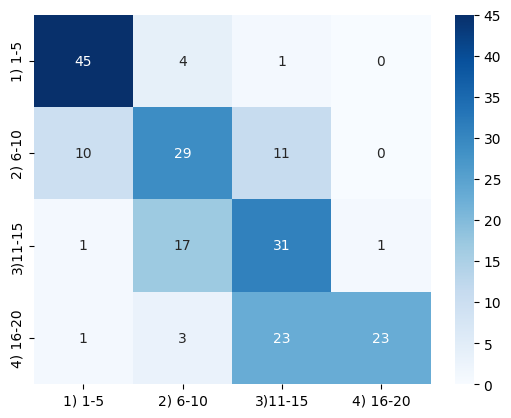

In [175]:
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, 
             cmap='Blues', xticklabels=np.unique(predictions), yticklabels=np.unique(predictions));

<AxesSubplot:xlabel='feature'>

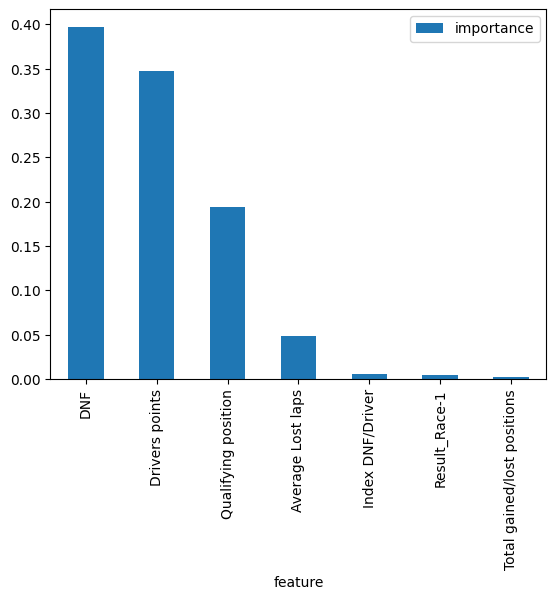

In [176]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(rnd_clf.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')

importances.plot.bar()

In [177]:
acierto = accuracy_score(y_test, predictions)

error = 1 - acierto
print("Acierto:", round(acierto*100, 2), "%")
print("Error:", round(error*100, 2), "%")

Acierto: 64.0 %
Error: 36.0 %


In [178]:
import pickle

with open('modeloDNF5-5.model', "wb") as archivo_salida:
    pickle.dump(rnd_clfCV.best_estimator_, archivo_salida)

### CONCLUSSIONS
- Our results are promising but there are still options to improve them. Of course getting more than a 50% in a 1/4 classifier and an 81.5% in a binary classifier are good numbers, but as we know our dataset, we can appreciate some of the biggest mistakes of our model:
  - For example, it cannot read and interpret DNF's, which mean most of our error.
  - It cannot understand properly the last 5 positions.
  - Usually tries an unbalanced number of 1's and 0's, which make it sure that there will be mistakes in every race.

- It is quite good predicting the first positions.
- Qualifying is very important to determine final position, mainly in the front rows.
- Random Forest Classifier is almost always the best option, although SVM sometimes does a good job in terms of accuracy of train, not as well when it comes to the test results, that are always overtaken by Random Forest Classifier

## SOLUTIONS

- Create an accurate DNF index that could predict this feature would be an interesting solution to imitate the good results that the real DNF column shows. It would be necessary, for example, check how dangerous is the first lap in each circuit, how many races have the different parts of the car taken in (to check how far are they to break), which drivers are more likely to an accident, etc.

- Find a way so it chooses the 10 drivers with more options to be 1, and the 10 drivers with more options to be 0, not just when a driver is above 0.5 in the predict proba.

- More data: weather as a randomizer, but also to check the laptimes with and without weather, different strategies, pit-stops, Safety-cars deployed, success in the first lap, etc.

- Find a way that allows our model to choose the last positions.